In [2]:
import torch
import pickle
import random
from tqdm import tqdm

In [3]:
import transformers

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [5]:
import os
from torchvision import models
from torch import nn as nn


In [6]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [7]:
from PIL import Image

In [8]:
import torchvision.transforms as transforms
from torch.autograd import Variable

In [9]:
import torch
from transformers import AutoTokenizer, AutoModel

In [37]:
agent_to_code = {}
agent_to_code['humans'] = 'a'
agent_to_code['azure'] = 'b'
agent_to_code['histogram'] = 'c'
agent_to_code['google'] = 'd'

code_to_agent = {}
code_to_agent['a'] = 'humans'
code_to_agent['b'] = 'azure'
code_to_agent['c'] = 'histogram'
code_to_agent['d'] = 'google'

In [38]:
# impath = "static/dataset/coco_val_set/%s.jpg"%fp.split('/')[-1].split('_')[0]

In [39]:
with open('color_to_bert.p','rb') as F:
    color_to_embedding = pickle.load(F)

In [40]:
color_to_embedding['none'] = color_to_embedding['white']

In [41]:
resnet_18 = models.resnet18(pretrained=True)
feature_model = nn.Sequential(*list(resnet_18.children())[:-1])
feature_model.eval();
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()    

In [42]:
def get_image_embedding(impath):
    img = Image.open(impath).convert('RGB')
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    img_embedding = feature_model(t_img)
    final_embedding = img_embedding[0,:,0,0]
    return final_embedding

In [43]:
# impath_to_embeddings = {}
# for htmlname in tqdm(os.listdir('static/responses_color/')):
#     imname = htmlname.split('_')[0]
#     impath = "static/dataset/coco_val_set/%s.jpg"%imname
#     if not impath in impath_to_embeddings.keys():
#         im_embedding = get_image_embedding(impath)
#         impath_to_embeddings[impath] = 'done'
#         with open('image_embeddings/%s.p'%imname,'wb') as F:
#             pickle.dump(im_embedding,F)

In [44]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

In [45]:
# import os
# os.mkdir('image_embeddings')

In [46]:
# with open('impath_to_embeddings.p','rb') as F:
#     impath_to_embeddings = pickle.load(F)

In [47]:
def read_data(allowed_algorithms = ['azure','histogram','google']):
    human_data = []
    ai_data = []

    for file in os.listdir('static/responses_color/'):
        fp = "static/responses_color/%s"%file
        if fp.endswith('html'):
            with open(fp,'r') as F:
                contents = F.readlines()
                color = contents[0].split(': ')[2].split('<')[0]
                speaker_type = code_to_agent[fp.split('_')[2]]
                impath = "static/dataset/coco_val_set/%s.jpg"%fp.split('/')[-1].split('_')[0]
            if speaker_type == 'humans':
                human_data.append([impath,color])
            else:
                if speaker_type in allowed_algorithms:
                    ai_data.append([impath,color])
    return human_data, ai_data

In [81]:
def splitted_embeddings(speaker_data,label_val = 0):
    train_data = speaker_data[:int(0.9*len(speaker_data))]
    val_data = speaker_data[int(0.9*len(speaker_data)):]
    
    X_train = np.zeros((len(train_data),1280))
    X_val = np.zeros((len(val_data),1280))
    
    Y_train = np.ones(len(train_data))*label_val
    Y_val = np.ones(len(val_data))*label_val
    
    train_im_paths = []
    test_im_paths = []
    
    for split in ['train','val']:
        if split == 'train':
            split_data = train_data
        elif split =='val':
            split_data = val_data

        for i in tqdm(range(len(split_data))):
            data = split_data[i]
            impath = data[0]
            color = data[1]
            embedding_path = impath.replace('static/dataset/coco','image_embeddings').replace('.jpg','.p')
            image_features = get_image_embedding(impath)
            cls_train = color_to_embedding[color]
            concatenated_features = torch.hstack((image_features, cls_train[0]))
            
            if split == 'train':
                X_train[i] = concatenated_features.detach()
                train_im_paths.append(impath)
            elif split == 'val':
                X_val[i] = concatenated_features.detach()
                test_im_paths.append(impath)
    
    return X_train, Y_train, X_val, Y_val, train_im_paths, test_im_paths

In [82]:
# all_colors = []
# for i in tqdm(range(len(human_data))):
#     data = human_data[i]
#     impath = data[0]
#     color = data[1]
#     all_colors.append(color)

In [83]:
# color_to_embedding = {}

In [84]:
# for possible_color in list(set(all_colors)):
#     tokenized_color = tokenizer([possible_color], padding = True, truncation = True, return_tensors="pt")
#     tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_color.items()}
#     with torch.no_grad():
#         hidden_train = model(**tokenized_train) 
#     cls_train = hidden_train.last_hidden_state[:,0,:]
#     color_to_embedding[possible_color] = cls_train

In [85]:
# with open('color_to_bert.p','wb') as F:
#     pickle.dump(color_to_embedding,F)

In [86]:
def embed_data(human_data, ai_data):
    random.shuffle(human_data)
    random.shuffle(ai_data)
    x_trainh,y_trainh,x_valh,y_valh,train_im_paths, test_im_paths = splitted_embeddings(human_data)
    x_traina,y_traina,x_vala,y_vala, train_im_paths, test_im_paths = splitted_embeddings(ai_data,1)
    x_train = np.vstack((x_trainh,x_traina))
    x_val = np.vstack((x_valh,x_vala))
    y_train = np.hstack((y_trainh,y_traina))
    y_val = np.hstack((y_valh,y_vala))
    
    return x_train,y_train,x_val,y_val,train_im_paths,test_im_paths

In [87]:
def classify_and_score(x_train,y_train,x_val,y_val, algo = 'SVM'):    
    if algo == 'RF':
        rf = RandomForestClassifier()
        rf.fit(x_train,y_train)
        predictions = rf.predict(x_val)
        score = rf.score(x_val,y_val) 
    elif algo == 'SVM':
        svm = SVC()
        svm.fit(x_train,y_train)
        predictions = svm.predict(x_val)
        score = svm.score(x_val,y_val) 
        
    conf_mat = confusion_matrix(y_val, predictions, normalize='true')
    return conf_mat, score, predictions

# All Combined

In [119]:
all_stds = {}

In [88]:
result_conf_mat = np.zeros((5,2))

In [89]:
human_data, ai_data = read_data()

In [90]:
len(human_data)

873

In [91]:
random.shuffle(ai_data)
ai_data = ai_data[:len(human_data)]
x_train,y_train,x_val,y_val,train_im_paths,test_im_paths = embed_data(human_data, ai_data)

100%|██████████| 88/88 [00:07<00:00, 12.48it/s]


In [93]:
# svm_conf, svm_score,predictions = classify_and_score(x_train,y_train,x_val,y_val,'RF')

In [97]:
svm_conf, svm_score,predictions = classify_and_score(x_train,y_train,x_val,y_val,'SVM')

In [98]:
svm_conf

array([[0.38636364, 0.61363636],
       [0.63636364, 0.36363636]])

In [99]:
svm_confs = {}

In [100]:
svm_score

0.375

In [101]:
svm_confs['all'] = svm_conf

In [102]:
svm_conf

array([[0.38636364, 0.61363636],
       [0.63636364, 0.36363636]])

In [103]:
result_conf_mat[0] = svm_conf[0]
result_conf_mat[1] = svm_conf[1]

In [120]:
y_val = y_val.astype('int')
predictions = predictions.astype('int')
all_stds['all'] = np.std(y_val == predictions)

# Humans vs Azure

In [122]:
human_data, ai_data = read_data(['azure'])
x_train,y_train,x_val,y_val,train_im_paths,test_im_paths = embed_data(human_data, ai_data)
svm_conf, svm_score,predictions = classify_and_score(x_train,y_train,x_val,y_val,'SVM')
result_conf_mat[2] = svm_conf[1]

100%|██████████| 88/88 [00:07<00:00, 12.53it/s]


In [123]:
svm_confs['azure'] = svm_conf

In [124]:
y_val = y_val.astype('int')
predictions = predictions.astype('int')
all_stds['azure'] = np.std(y_val == predictions)

# Humans vs Histogram

In [127]:
human_data, ai_data= read_data(['histogram'])
x_train,y_train,x_val,y_val,train_im_paths,test_im_paths = embed_data(human_data, ai_data)
svm_conf, svm_score,predictions = classify_and_score(x_train,y_train,x_val,y_val,'RF')
result_conf_mat[3] = svm_conf[1]

100%|██████████| 88/88 [00:06<00:00, 12.77it/s]


In [128]:
y_val = y_val.astype('int')
predictions = predictions.astype('int')
all_stds['histogram'] = np.std(y_val == predictions)

In [129]:
svm_confs['histogram'] = svm_conf

# Humans vs Google

In [130]:
human_data, ai_data = read_data(['google'])
x_train,y_train,x_val,y_val,train_im_paths,test_im_paths = embed_data(human_data, ai_data)
svm_conf, svm_score,predictions = classify_and_score(x_train,y_train,x_val,y_val,'RF')
result_conf_mat[4] = svm_conf[1]

100%|██████████| 88/88 [00:06<00:00, 12.69it/s]


In [131]:
y_val = y_val.astype('int')
predictions = predictions.astype('int')
all_stds['google'] = np.std(y_val == predictions)

In [132]:
svm_confs['google'] = svm_conf

# Plotting

In [135]:
# modelist = ['Azure','Histogram','Google']

# plotname = 'dominant_color_recognition'

# import os
# os.makedirs('figures',exist_ok=True)

# #plot confusion matrix
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt

# df_cm = pd.DataFrame(result_conf_mat, index = [i for i in ['Human','AI']+modelist],
#                   columns = [i for i in ['Human','AI']])
# plt.figure(figsize =  (1.2,3.5))
# sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1)
# plt.xlabel("Predicted")
# plt.ylabel("Ground Truth")

# plt.savefig('figures/' + plotname + '_bert_confmat.pdf', bbox_inches='tight')
# plt.show()

In [137]:
all_stds

{'all': 0.4841229182759271,
 'azure': 0.4758840728858723,
 'histogram': 0.4926827701305081,
 'google': 0.4953294254023492}

In [139]:
# top1

[[0.38636364 0.61363636]
 [0.63636364 0.36363636]
 [0.72727273 0.27272727]
 [0.44318182 0.55681818]
 [0.57954545 0.42045455]]
[0.375, 0.32954545454545453, 0.47159090909090906, 0.40340909090909094]


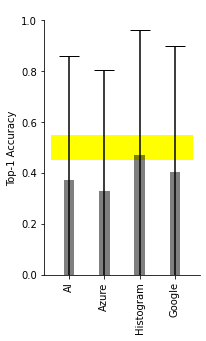

In [141]:
#compute top 1 accuracy for each AI model and also overall AI
top1 = []
print(result_conf_mat)
for i in range(1+len(modelist)):
    #print(i)
    top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
print(top1)

import matplotlib.pyplot as plt
import numpy as np
 
#data
#x-axis
years = list(range(1, 2+len(modelist)))
strtask = ['AI'] + modelist
#print(years)
#print(strtask)

# Figure Size
fig, ax = plt.subplots()

from matplotlib.patches import Rectangle
ax.add_patch(Rectangle((-0.5, 0.45), len(top1), 0.1,facecolor='yellow'))

#bar chart properties
# ax.bar(strtask, top1, color ='black', width = 0.3)
ax.bar(strtask, top1, yerr=all_stds.values(),
       align='center', alpha=0.5, ecolor='black', capsize=10,
       color ='black', width = 0.3)
  
plt.ylabel('Top-1 Accuracy')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

plt.ylim(0, 1)
#plt.xlim(0.5, len(years)+0.5)

#draw chance 0.5 
# chancex =np.arange(len(years))
# plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
#plt.legend()
 
fig.tight_layout()

fig.set_figwidth(2.5)
fig.set_figheight(5)

fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
fig.savefig('figures/' + plotname + '_bert.pdf', bbox_inches='tight')